In [366]:
import gmsh
import meshio
import numpy
import pygmsh
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subprocess

In [367]:
resolution = 0.01
LT = 10
LB = 10
W = 5

point0 = (0, 0, 0)
point1 = (LB, 0, 0)
point2 = (LT, W, 0)
point3 = (0, W, 0)

centers = [
           (1, 1, 0),
           (3, 1, 0),
           (5, 1, 0),
           (7, 1, 0),
           (9, 1, 0),
           (2, 2.5, 0),
           (4, 2.5, 0),
           (6, 2.5, 0),
           (8, 2.5, 0),
           (1, 4.10, 0),
           (3, 4.10, 0),
           (5, 4.10, 0),
           (7, 4.10, 0),
           (9, 4.10, 0),

]
r = 0.90

In [368]:
geometry = pygmsh.geo.Geometry()
model = geometry.__enter__()

In [369]:
points = [model.add_point(point0, mesh_size=resolution),
          model.add_point(point1, mesh_size=resolution),
          model.add_point(point2, mesh_size=resolution),
          model.add_point(point3, mesh_size=resolution),
          ]

In [370]:
channel_lines = [model.add_line(points[i], points[i+1])
  for i in range(-1, len(points)-1)]
channel_loop = model.add_curve_loop(channel_lines)
circles = [model.add_circle(c, r, mesh_size=resolution) for c in centers]
holes = [circle.curve_loop for circle in circles]
plane_surface = model.add_plane_surface(channel_loop, holes=holes)
model.synchronize()

In [371]:
volume_marker = 6
model.add_physical([plane_surface], "Volume")
model.add_physical([channel_lines[0]], "Left")
model.add_physical([channel_lines[2]], "Right")
model.add_physical([channel_lines[1], channel_lines[3]], "Insulated")
for i, c in enumerate(circles):
    model.add_physical(c.curve_loop.curves, "void%d" % i)

In [372]:
geometry.generate_mesh(dim=2)
gmsh.write("mesh.msh")
gmsh.clear()
geometry.__exit__()

In [373]:
mesh_from_file = meshio.read("mesh.msh")

In [374]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

In [375]:
line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write("facet_mesh.xdmf", line_mesh)

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh.xdmf", triangle_mesh)


In [376]:
cmd = 'mpirun -n 2 python3 demo_poisson.py'
!{cmd}

done loading triangular mesh
done loading triangular mesh


In [377]:
# load simulation results
with h5py.File("poisson.h5", 'r') as hf:
    values = hf.get("Function/f_4/0")[:]
    positions = hf.get("Mesh/Grid/geometry")[:]

positions = np.around(positions, 2)
results = np.hstack((positions, values))

In [378]:
idx = np.lexsort((results[:, 0], results[:, 1]))
results = results[idx]
results = pd.DataFrame(results, columns=['x', 'y', 'u'])
results = results.groupby(['x', 'y']).mean('u')
results.reset_index(inplace=True)
results.head(10)

,x,y,u
0,0.0,0.00,1.0
1,0.0,0.01,1.0
2,0.0,0.02,1.0
3,0.0,0.03,1.0
4,0.0,0.04,1.0
5,0.0,0.05,1.0
6,0.0,0.06,1.0
7,0.0,0.07,1.0
8,0.0,0.08,1.0
9,0.0,0.09,1.0


In [379]:
results = results.to_numpy()
x_series = np.arange(0, 10.01, 0.01)
y_series = np.arange(0, 5.01, 0.01)

grad_data = np.zeros(results.shape)
avg_cond = []
for y_val in y_series:
    results_slice = results[np.where(np.isclose(results[:, 1], y_val))]
    results_slice = results_slice[np.argsort(results_slice[:, 0])]
    x_vals = results_slice[:, 0] / 10
    u_vals = results_slice[:, 2]
    grad = -np.divide(u_vals[1:] - u_vals[:-1], x_vals[1:] - x_vals[:-1])
    avg_cond.append(np.average(grad))

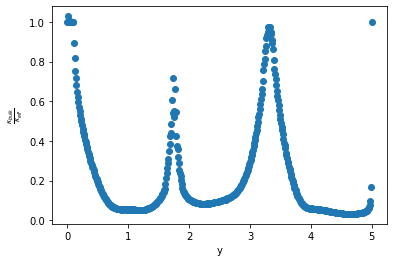

['Effective Conductivity: ', 0.21770006569869546]

In [381]:
plt.scatter(y_series, avg_cond)
plt.xlabel(r'y')
plt.ylabel(r'$\frac{\kappa_{bulk}}{\kappa_{eff}}$')
plt.show()
["Effective Conductivity: ", np.average(avg_cond), ]